In [1]:
## FIRE PREDICTION ##

## import libraries
import pandas as pd
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

## read all files
fire1 = pd.read_csv('modis_2018_India.csv', parse_dates=['acq_date'])
fire2 = pd.read_csv('modis_2019_India.csv', parse_dates=['acq_date'])
fire3 = pd.read_csv('modis_2020_India.csv', parse_dates=['acq_date'])

fire1.index = pd.to_datetime(fire1.index, unit='s')
fire2.index = pd.to_datetime(fire2.index, unit='s')
fire3.index = pd.to_datetime(fire3.index, unit='s')

In [2]:
# merge the files into one dataframe
df = fire1.append(fire2)
df = df.append(fire3)

df.index = pd.to_datetime(df.index, unit='s')

In [3]:
## dropping the unwanted variables from the dataframe
cols = ['latitude','longitude', 'brightness', 'scan', 'track', 'acq_time', 'satellite', 'instrument', 'confidence', 'version', 'bright_t31', 'daynight', 'type']
df.drop(cols, axis=1, inplace=True)

In [4]:
# filling the null values using the sum(). Filling the missing data
df.isnull().sum()

acq_date    0
frp         0
dtype: int64

In [5]:
# grouping the data for each month using sum
df.acq_date = pd.to_datetime(df.acq_date)
df = df.groupby(pd.Grouper(key='acq_date', freq='1M')).sum() # groupby each 1 month
#df.index = df.index.strftime('%Y-%B')

In [6]:
df

,frp
acq_date,
2018-01-31,90963.8
2018-02-28,189861.9
2018-03-31,1094019.0
2018-04-30,355666.0
2018-05-31,222508.0
2018-06-30,13736.9
2018-07-31,2934.0
2018-08-31,3231.2
2018-09-30,8132.4


In [7]:
# sampling from the required variable and taking its mean and setting the value of y
y = df['frp'].resample('MS').mean()

In [8]:
y['2018':]

acq_date
2018-01-01      90963.8
2018-02-01     189861.9
2018-03-01    1094019.0
2018-04-01     355666.0
2018-05-01     222508.0
2018-06-01      13736.9
2018-07-01       2934.0
2018-08-01       3231.2
2018-09-01       8132.4
2018-10-01      94325.3
2018-11-01     207282.6
2018-12-01      46416.3
2019-01-01      84495.9
2019-02-01     141585.2
2019-03-01     836869.8
2019-04-01     453513.5
2019-05-01     338288.5
2019-06-01      31487.4
2019-07-01       6746.1
2019-08-01       4450.7
2019-09-01       4423.6
2019-10-01     100509.6
2019-11-01     125961.6
2019-12-01      35256.9
2020-01-01      41072.7
2020-02-01      87443.6
2020-03-01     770733.1
2020-04-01     417642.4
2020-05-01     166963.5
2020-06-01       8647.5
2020-07-01       5818.1
2020-08-01       4755.1
2020-09-01       7329.0
2020-10-01     154881.7
2020-11-01     267767.1
2020-12-01      77602.8
Freq: MS, Name: frp, dtype: float64

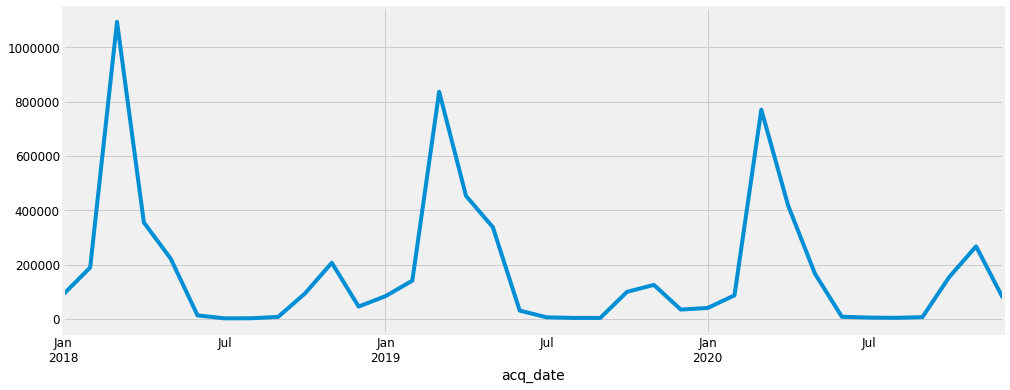

In [9]:
# plotting frp values over time
y.plot(figsize=(15, 6))
plt.show()

In [10]:
#from pylab import rcParams
#rcParams['figure.figsize'] = 18, 8
#decomposition = sm.tsa.seasonal_decompose(y, model='additive')
#fig = decomposition.plot()
#plt.show()

In [11]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [12]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:987.2958162181988
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:591.7474739033269
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:606.4039466342895
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:306.5890661499174
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:955.2640075151669
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:570.825617924832
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:643.3207445875981
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:306.84656007983966
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:955.2646739504175
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:577.3873538891071
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:588.8714072449997
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:281.9477232286782
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:907.0685138452748
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:531.3030810079509
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:617.4000354051443
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:281.1822378226896
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:975.7743043596457
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:590.0222062116896
ARIMA(1, 0

In [13]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5603      0.421     -1.330      0.183      -1.386       0.265
ma.L1         -0.1091      0.574     -0.190      0.849      -1.235       1.017
ar.S.L12      -0.2324      0.117     -1.993      0.046      -0.461      -0.004
sigma2      3.481e+09   2.48e-11   1.41e+20      0.000    3.48e+09    3.48e+09


In [14]:
#results.plot_diagnostics(figsize=(16, 8))
#plt.show()

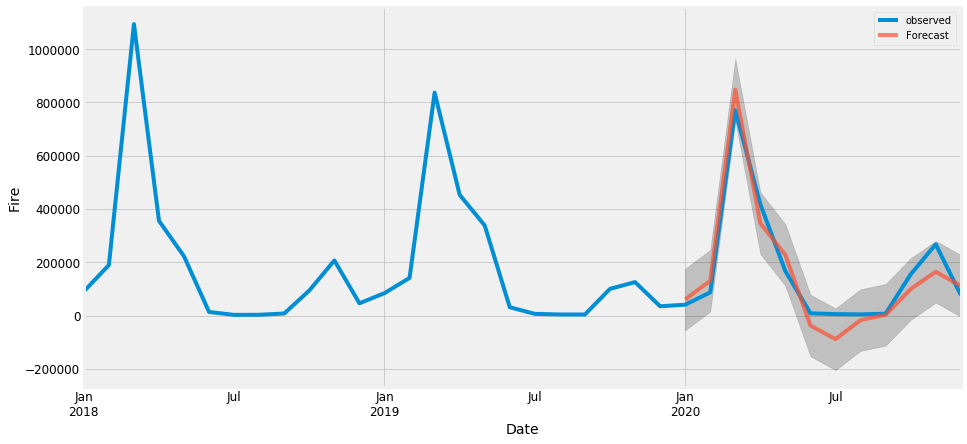

In [15]:
pred = results.get_prediction(start=pd.to_datetime('2020-01-01'), dynamic=False) # forecasting fire in 2020
pred_ci = pred.conf_int() # setting confidence interval around the predicted data
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date') # defining x-axis label
ax.set_ylabel('Fire') # defining y-axis label
plt.legend() # adding legend to the plot
plt.show()